In [1]:
import glob
from datetime import datetime
from datetime import timedelta
import numpy as np
import pandas as pd
import xarray as xr
import multiprocessing as mp
import matplotlib.pyplot as plt

/glade/work/jhayron/conda-envs/cnn_wr/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# full_dataset = xr.open_dataset('/glade/derecho/scratch/jhayron/PRECIP_ERA5_Daily.nc')
# data_mm = full_dataset.PrecipitationRate * 3600
# data_mm_day = data_mm * 24
# data_mm_day.attrs['long_name'] = 'Daily cumulative precipitation'
# data_mm_day.attrs['units'] = 'mm/day'
# data_mm_day = data_mm_day.to_dataset(name='DailyPrecip')
# data_mm_day.to_netcdf('/glade/derecho/scratch/jhayron/PRECIP_ERA5_Daily_mm.nc')

In [3]:
data_mm_day = xr.open_dataset('/glade/derecho/scratch/jhayron/PRECIP_ERA5_Daily_mm.nc')
data_mm_day = data_mm_day.sel(time=slice('1940-01-01','2023-12-31'))

In [4]:
DailyPrecip = data_mm_day.DailyPrecip

In [11]:
climatology = (
    DailyPrecip.groupby('time.dayofyear')
    .mean(dim='time')
    .rename({'dayofyear': 'day'})
)

In [12]:
climatology_padded = xr.concat([climatology[-30:], climatology, climatology[:30]], dim='day')
climatology_smoothed = climatology_padded.rolling(day=60, center=True).mean()

In [13]:
climatology_smoothed = climatology_smoothed.isel(day=slice(30, -30))

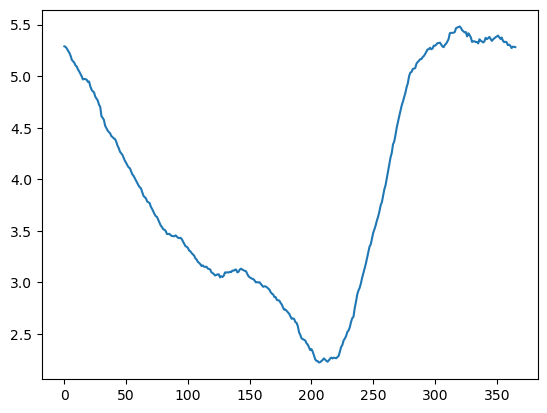

In [17]:
plt.plot(climatology_smoothed.sel(lat = 45, lon = 210))

In [23]:
climatology_expanded = xr.DataArray(
    climatology_smoothed.sel(day=DailyPrecip['time.dayofyear']),
    dims=["time", "lat", "lon"],
    coords={"time": DailyPrecip['time'], "lat": DailyPrecip['lat'], "lon": DailyPrecip['lon']}
)

In [30]:
precipitation_anomalies = DailyPrecip - climatology_expanded

In [33]:
precipitation_anomalies = precipitation_anomalies.to_dataset(name = 'PrecipAnoms')

In [38]:
precipitation_anomalies.to_netcdf('/glade/derecho/scratch/jhayron/PRECIP_ERA5_DailyAnoms_mm.nc')

In [39]:
precipitation_anomalies

<xarray.Dataset>
Dimensions:      (lat: 321, lon: 521, time: 30681)
Coordinates:
  * lat          (lat) float64 10.0 10.25 10.5 10.75 ... 89.25 89.5 89.75 90.0
  * lon          (lon) float64 180.0 180.2 180.5 180.8 ... 309.5 309.8 310.0
  * time         (time) datetime64[ns] 1940-01-01 1940-01-02 ... 2023-12-31
Data variables:
    PrecipAnoms  (time, lat, lon) float32 -3.03 -2.966 ... -0.3944 -0.3944

# climatology_std

In [5]:
climatology_std = (
    DailyPrecip.groupby('time.dayofyear')
    .std(dim='time')
    .rename({'dayofyear': 'day'})
)

In [6]:
climatology_std_padded = xr.concat([climatology_std[-30:], climatology_std, climatology_std[:30]], dim='day')
climatology_std_smoothed = climatology_std_padded.rolling(day=60, center=True).mean()

In [7]:
climatology_std_smoothed = climatology_std_smoothed.isel(day=slice(30, -30))

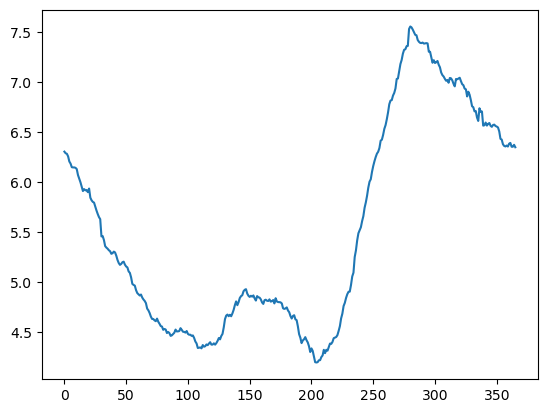

In [8]:
plt.plot(climatology_std_smoothed.sel(lat = 45, lon = 210))

In [9]:
precipitation_anomalies = xr.open_dataset('/glade/derecho/scratch/jhayron/PRECIP_ERA5_DailyAnoms_mm.nc')
PrecipAnoms = precipitation_anomalies.PrecipAnoms

In [15]:
climatology_std_expanded = xr.DataArray(
    climatology_std_smoothed.sel(day=DailyPrecip['time.dayofyear']),
    dims=["time", "lat", "lon"],
    coords={"time": DailyPrecip['time'], "lat": DailyPrecip['lat'], "lon": DailyPrecip['lon']}
)

In [16]:
precipitation_anomalies_std = PrecipAnoms/climatology_std_expanded

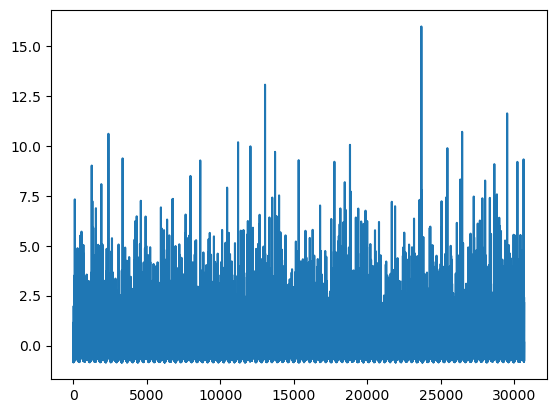

In [17]:
plt.plot(precipitation_anomalies_std.sel(lon = 210, lat=45))

In [18]:
precipitation_anomalies_std = precipitation_anomalies_std.to_dataset(name = 'PrecipAnomsStd')

In [19]:
precipitation_anomalies_std.to_netcdf('/glade/derecho/scratch/jhayron/PRECIP_ERA5_DailyAnoms_Std.nc')

In [20]:
precipitation_anomalies_std

<xarray.Dataset>
Dimensions:         (lat: 321, lon: 521, time: 30681)
Coordinates:
  * lat             (lat) float64 10.0 10.25 10.5 10.75 ... 89.5 89.75 90.0
  * lon             (lon) float64 180.0 180.2 180.5 180.8 ... 309.5 309.8 310.0
  * time            (time) datetime64[ns] 1940-01-01 1940-01-02 ... 2023-12-31
Data variables:
    PrecipAnomsStd  (time, lat, lon) float32 -0.5911 -0.5745 ... -0.5348 -0.5348